In [6]:
import tensorflow as tf
import os
import cv2
import imghdr

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
data_dir = './CT Lung Mask' 

In [10]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [12]:
for image_class in os.listdir(data_dir): 
    print('Looking for images in {}'.format(image_class))
    if image_class == '.DS_Store':
        continue
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Looking for images in LUNG-030_28.jpg


NotADirectoryError: [Errno 20] Not a directory: './CT Lung Mask/LUNG-030_28.jpg'

### Load Data

In [13]:
import numpy as np
from matplotlib import pyplot as plt

In [16]:
data = tf.keras.utils.image_dataset_from_directory('./CT Lung Mask/')

Found 4941 files belonging to 2 classes.


2023-11-17 18:29:49.070985: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2023-11-17 18:29:49.071018: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-11-17 18:29:49.071023: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-11-17 18:29:49.071105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-17 18:29:49.071402: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
data_iterator = data.as_numpy_iterator()

In [18]:
batch = data_iterator.next()

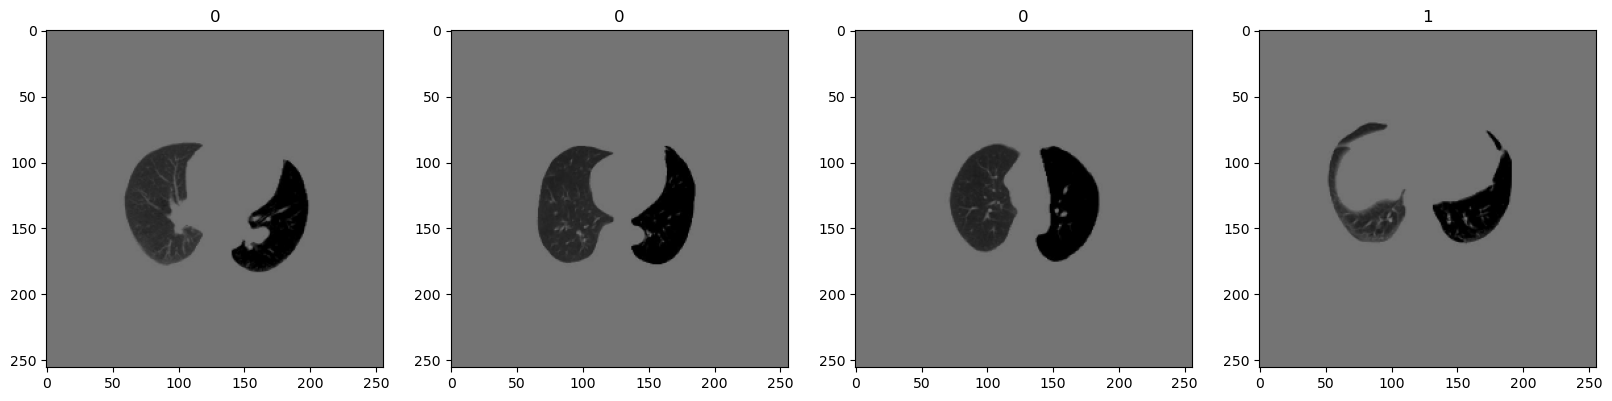

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Data Prep

In [20]:
data = data.map(lambda x,y: (x/255, y))

In [21]:
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Gather all image filenames and their respective patient IDs
image_path = './CT Lung Mask'
class_folders = ['Class 0', 'Class 1']
filepaths = []
patient_ids = []

# Collect files and patient IDs
for class_folder in class_folders:
    full_path = os.path.join(image_path, class_folder)
    for filename in os.listdir(full_path):
        if filename.endswith('.jpg'):
            patient_id = filename.split('_')[0]  # Assuming filename format "CaseID_number.jpg"
            filepaths.append(os.path.join(full_path, filename))
            patient_ids.append(patient_id)

# Get unique patient IDs and split them
unique_patient_ids = np.unique(patient_ids)
train_ids, test_ids = train_test_split(unique_patient_ids, test_size=0.3, random_state=42)  # Splitting off test set
train_ids, val_ids = train_test_split(train_ids, test_size=0.5, random_state=42)  # Adjusting validation split

# Function to filter filenames based on patient IDs
def filter_filenames(ids, filepaths, patient_ids):
    return [path for path, pid in zip(filepaths, patient_ids) if pid in ids]

# Filter filenames for each split based on the unique patient ID they belong to
train_files = filter_filenames(train_ids, filepaths, patient_ids)
val_files = filter_filenames(val_ids, filepaths, patient_ids)
test_files = filter_filenames(test_ids, filepaths, patient_ids)


In [22]:
# Assuming you have a function to retrieve labels from file paths
def get_label(file_path):
    # Extract class from file path and return the label as an integer
    return 0 if 'Class 0' in file_path else 1

def preprocess_image(image):
    # Decode the image, resize it and scale the pixel values
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])  # Resize the image to the desired size
    image = tf.cast(image, tf.float32) / 255.0  # Scale the image to [0, 1] range and convert to float32
    return image

# Assuming 'train_files', 'val_files', and 'test_files' are lists of filepaths for the images
def create_dataset(file_paths):
    labels = [get_label(fp) for fp in file_paths]  # Retrieve labels using the get_label function
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(lambda fp, lbl: (preprocess_image(tf.io.read_file(fp)), lbl),
                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return ds

# Create datasets for training, validation, and testing
train_data = create_dataset(train_files)
val_data = create_dataset(val_files)
test_data = create_dataset(test_files)

# Batch the datasets
train = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val = val_data.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test = test_data.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [23]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Building Model

In [24]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [26]:
model = Sequential()

In [27]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

### Training

In [30]:
logdir='logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-11-17 18:30:31.754384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 9s 105ms/step - loss: 0.5693 - accuracy: 0.7612 - val_loss: 0.6703 - val_accuracy: 0.6856
Epoch 2/20
50/50 [==============================] - 4s 78ms/step - loss: 0.6446 - accuracy: 0.7448 - val_loss: 0.6238 - val_accuracy: 0.7109
Epoch 3/20
50/50 [==============================] - 4s 81ms/step - loss: 0.5578 - accuracy: 0.7852 - val_loss: 0.5687 - val_accuracy: 0.7251
Epoch 4/20
50/50 [==============================] - 4s 80ms/step - loss: 0.4599 - accuracy: 0.7871 - val_loss: 0.5576 - val_accuracy: 0.7320
Epoch 5/20
50/50 [==============================] - 4s 78ms/step - loss: 0.4183 - accuracy: 0.8193 - val_loss: 0.5607 - val_accuracy: 0.7299
Epoch 6/20
50/50 [==============================] - 4s 80ms/step - loss: 0.3688 - accuracy: 0.8497 - val_loss: 0.5618 - val_accuracy: 0.7351
Epoch 7/20
50/50 [==============================] - 4s 69ms/step - loss: 0.3142 - accuracy: 0.8623 - val_loss: 0.6198 - val_accuracy: 0.7578
Epoch 8/20
50/50 [=====

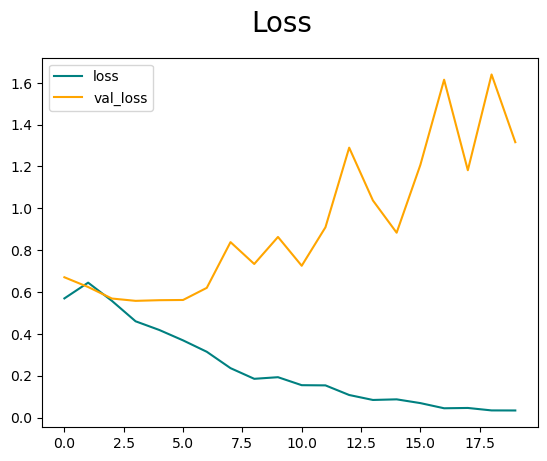

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

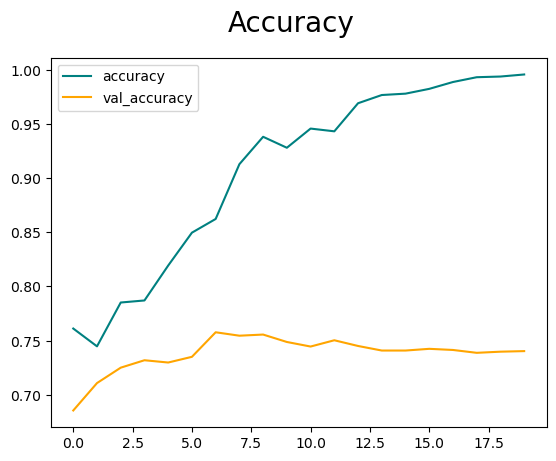

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Testing

In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 96ms/step


In [38]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.801131, shape=(), dtype=float32) tf.Tensor(0.84745765, shape=(), dtype=float32) tf.Tensor(0.75051403, shape=(), dtype=float32)


### Save Model

In [39]:
from tensorflow.keras.models import load_model

In [43]:
model.save(os.path.join('models','2D_CNN_image_classifier.keras'))
#save weights
model.save_weights(os.path.join('models','2D_CNN_image_classifier_weights.keras'))